In [2]:
# Importando librerias necesarias
import cv2 as cv
import numpy as np

from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import approximate_polygon

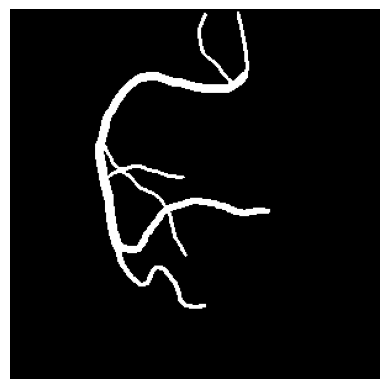

In [4]:
image_path = 'images/1_gt.pgm'
imagen_color = cv.imread(image_path)
imagen_gris = cv.cvtColor(imagen_color, cv.COLOR_BGR2GRAY)
_, binary_image = cv.threshold(imagen_gris, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.show()

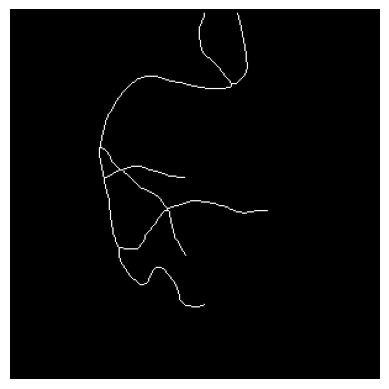

In [5]:
skeleton = skeletonize(binary_image)
plt.imshow(skeleton, cmap='gray')
plt.axis('off')
plt.show()

In [8]:
all_nodes_list = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j]: all_nodes_list.append((i, j))

all_nodes_list = np.array(all_nodes_list)

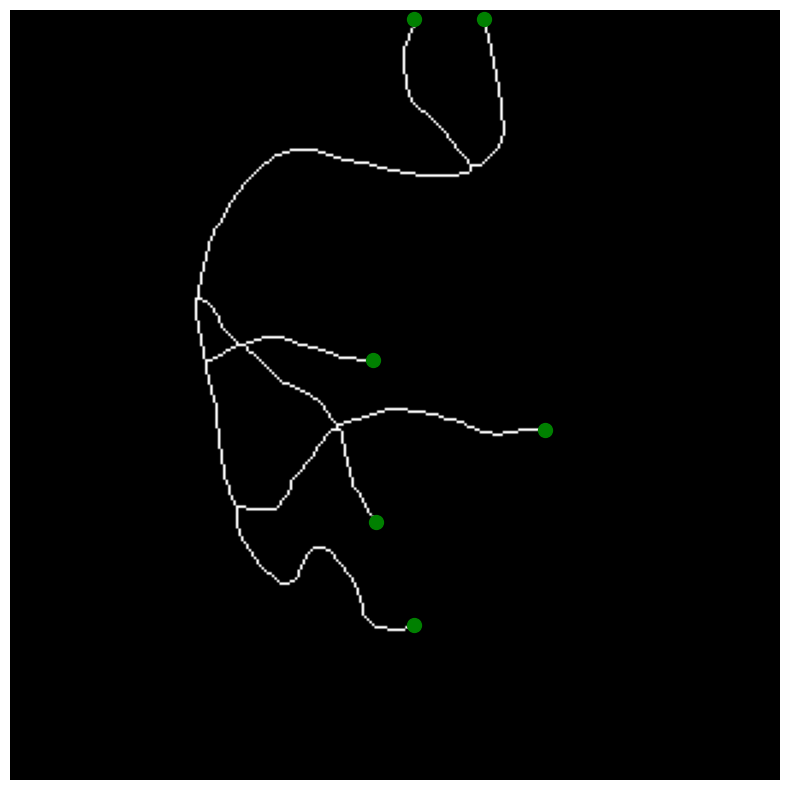

In [7]:
extreme_nodes_list = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j]:
            rows, columns = np.ogrid[i-1:i+2, j-1:j+2]
            if np.sum(skeleton[rows, columns]) == 2:
                extreme_nodes_list.append((i, j))


plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=10)

plt.axis('off')
plt.show()

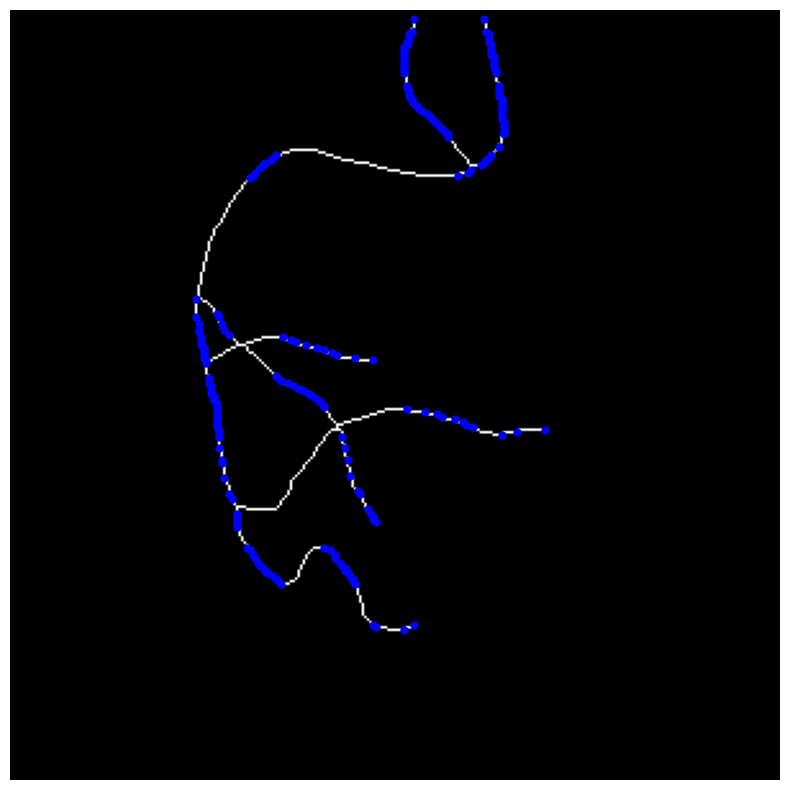

In [23]:
tolerance = 5
ap = approximate_polygon(all_nodes_list, tolerance)

plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in ap], 
         [node[0] for node in ap], 
         'o',
         color='blue',
         markersize=5)
plt.axis('off')
plt.show()

In [40]:
# Bifurcaciones y Trifurcaciones

# Bifurcation - Nodo con 3 vecinos
# Trifurcation - Nodo con 4 vecinos

bifurcation_nodes_list = []
trifurcation_nodes_list = []

for i in range(1, skeleton.shape[0] - 1):
		for j in range(1, skeleton.shape[1] - 1):
				if skeleton[i, j]:
						# Check if is not already in either list
						right = skeleton[i, j+1] and (i, j+1) not in bifurcation_nodes_list and (i, j+1) not in trifurcation_nodes_list
						left = skeleton[i, j-1] and (i, j-1) not in bifurcation_nodes_list and (i, j-1) not in trifurcation_nodes_list
						up = skeleton[i-1, j] and (i-1, j) not in bifurcation_nodes_list and (i-1, j) not in trifurcation_nodes_list
						down = skeleton[i+1, j] and (i+1, j) not in bifurcation_nodes_list and (i+1, j) not in trifurcation_nodes_list
						upper_left = skeleton[i-1, j-1] and (i-1, j-1) not in bifurcation_nodes_list and (i-1, j-1) not in trifurcation_nodes_list
						upper_right = skeleton[i-1, j+1] and (i-1, j+1) not in bifurcation_nodes_list and (i-1, j+1) not in trifurcation_nodes_list
						lower_left = skeleton[i+1, j-1] and (i+1, j-1) not in bifurcation_nodes_list and (i+1, j-1) not in trifurcation_nodes_list
						lower_right = skeleton[i+1, j+1] and (i+1, j+1) not in bifurcation_nodes_list and (i+1, j+1) not in trifurcation_nodes_list
						neighbors = [right, left, up, down, upper_left, upper_right, lower_left, lower_right]
						neighbors_sum = np.sum(neighbors)
						# Trifurcation has higher priority
						if neighbors_sum == 4:
								trifurcation_nodes_list.append((i, j))
						elif neighbors_sum == 3:
								bifurcation_nodes_list.append((i, j))
						


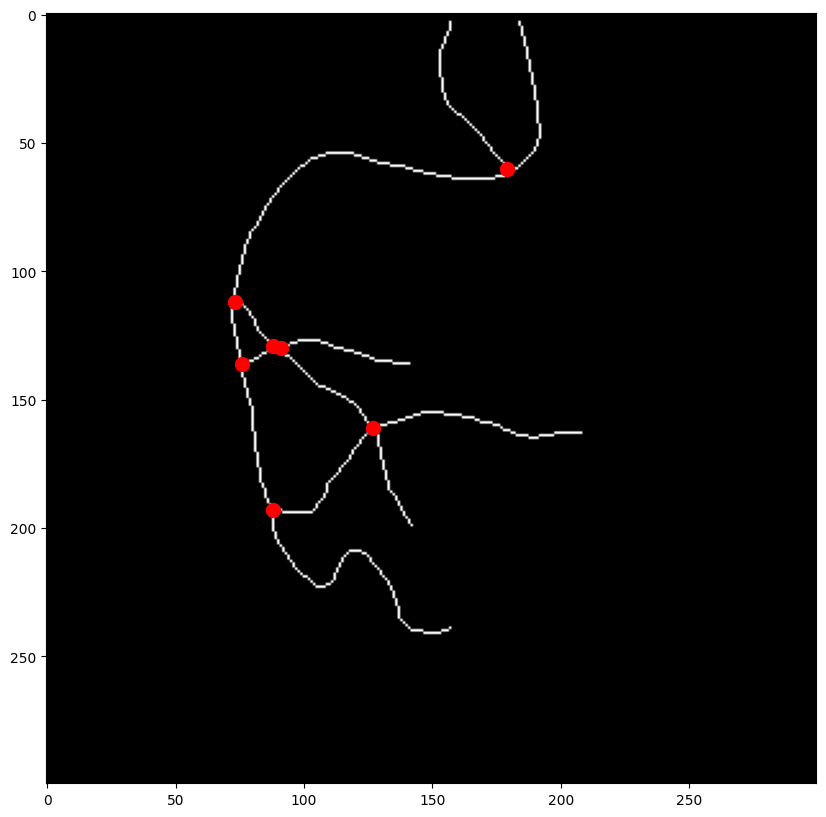

In [41]:
# Plot bifurcation in green

plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=10)

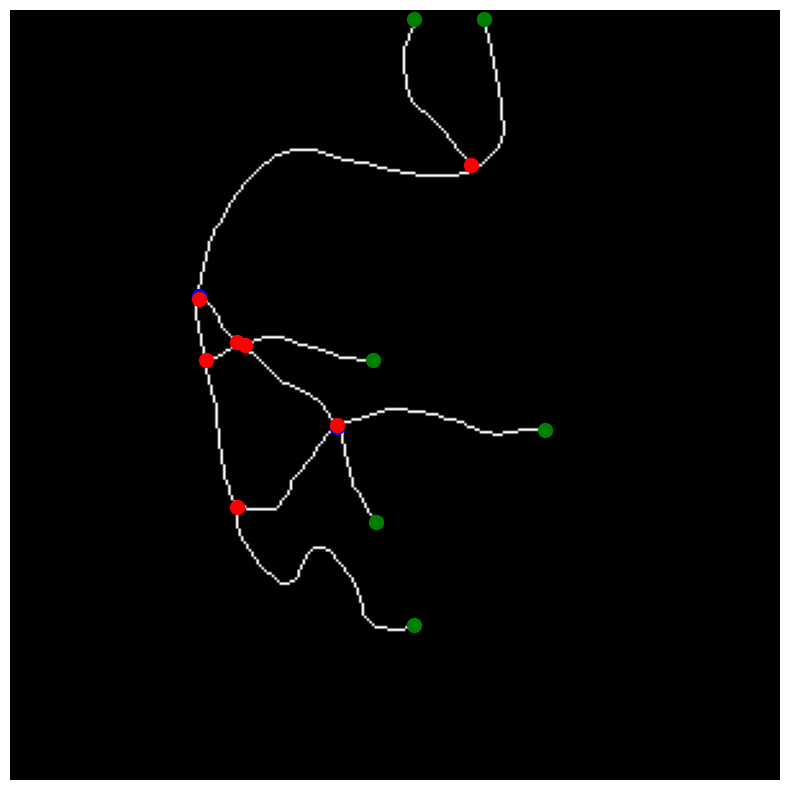

In [43]:
# Plot bifurcation in red
# Plot trifurcation in blue
plt.figure(figsize=(10,10))
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=10)
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=10)

plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=10)

plt.axis('off')
plt.show()

(-0.5, 299.5, 299.5, -0.5)

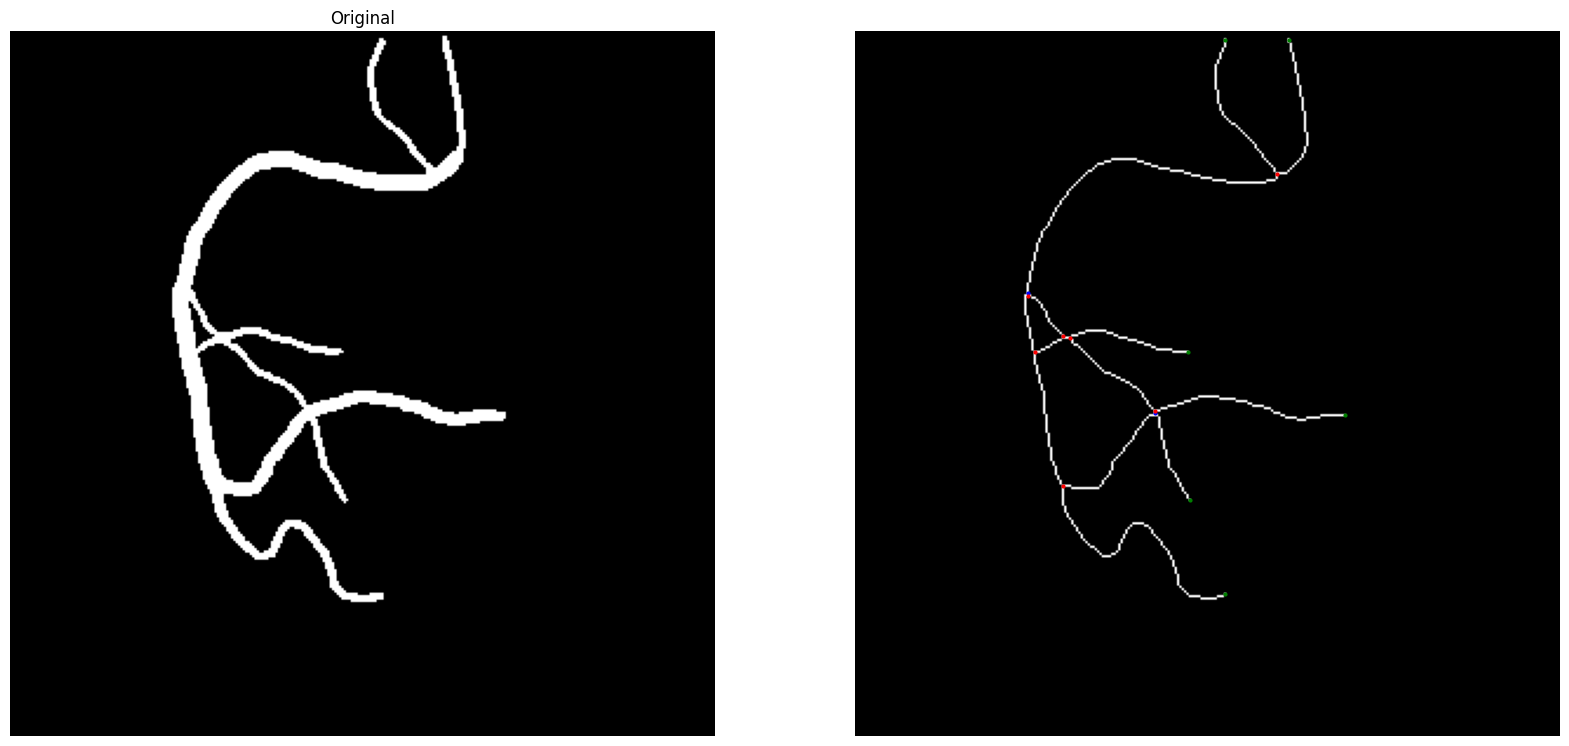

In [51]:
# Plot original image and the resulting side by side
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(imagen_color)
plt.axis('off')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(skeleton, cmap='gray')
plt.plot([node[1] for node in trifurcation_nodes_list], 
				 [node[0] for node in trifurcation_nodes_list], 
				 'bo',
					markersize=5)
plt.plot([node[1] for node in bifurcation_nodes_list], 
				 [node[0] for node in bifurcation_nodes_list], 
				 'ro',
					markersize=5)

plt.plot([node[1] for node in extreme_nodes_list], 
         [node[0] for node in extreme_nodes_list], 
         'go',
          markersize=5)

plt.axis('off')

